In [1]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

df = pd.read_csv('sc2egset.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'FIXED_sc2egset_csv.csv'

In [ ]:
# Filter out short matches and convert outcome values to int
df = df[(df.outcome.isin(['Win', 'Loss'])) & (df.game_time_gameloop > 12000)]
df['outcome'] = [1 if i == 'Win' else 0 for i in df.outcome]

In [ ]:
# Filter out errant gameloops and ensure that the match represents only two players
grouped = df.groupby('gameloop')['game_hash'].nunique().reset_index()
good_loops = grouped[grouped.game_hash > 1000]['gameloop'].tolist()

grouped = df.groupby('game_hash')['player_name'].agg(list).reset_index()
grouped['player_count'] = [len(set(i)) for i in grouped.player_name]
correct_players = grouped[grouped.player_count == 2]['game_hash'].tolist()

df = df[(df.gameloop.isin(good_loops)) & (df.game_hash.isin(correct_players))]

In [ ]:
# Define function to apply all three models to each time point in match, same approach as in classification made for time-aggregated data
def timepoint_fit(data, time):

    data = data[data.gameloop == time]

    model_features = ['foodMade', 'foodUsed', 'mineralsCollectionRate', 'mineralsCurrent', 'mineralsKilledArmy', 'mineralsKilledEconomy',
                      'mineralsKilledTechnology', 'mineralsUsedCurrentArmy', 'mineralsUsedCurrentEconomy', 'mineralsUsedCurrentTechnology',
                      'vespeneCollectionRate', 'vespeneCurrent', 'vespeneKilledArmy', 'vespeneKilledTechnology',
                      'vespeneUsedCurrentArmy', 'vespeneUsedCurrentEconomy', 'vespeneUsedCurrentTechnology', 'workersActiveCount']

    from sklearn import preprocessing
    import numpy as np

    min_count = data.outcome.value_counts().min()
    df_model = data.groupby('outcome').sample(n=min_count)

    random_state = 22

    y = np.array(df_model['outcome'], dtype=int)
    X = np.asarray(df_model[model_features])
    X = preprocessing.StandardScaler().fit(X).transform(X)

    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import KFold

    cv = KFold(n_splits=5, shuffle=True, random_state=random_state)

    import xgboost
    xgb = xgboost.XGBClassifier(objective="binary:logistic", booster='gbtree', eta=0.2, max_depth=5, use_label_encoder=False, verbosity=0, random_state=random_state)
    xgb_scores = cross_val_score(xgb, X, y, cv=cv, n_jobs=-1)
    print("XGBoost: %0.4f accuracy with a standard deviation of %0.4f" % (xgb_scores.mean(), xgb_scores.std()))

    from sklearn import svm
    sv = svm.SVC(kernel='rbf', C=10, gamma='auto', random_state=random_state)
    sv_scores = cross_val_score(sv, X, y, cv=cv, n_jobs=-1)
    print("SVM: %0.4f accuracy with a standard deviation of %0.4f" % (sv_scores.mean(), sv_scores.std()))

    from sklearn.linear_model import LogisticRegression
    lr = LogisticRegression(C=10, penalty='l2', random_state=random_state)
    lr_scores = cross_val_score(lr, X, y, cv=cv, n_jobs=-1)
    print("Logistic Regression: %0.4f accuracy with a standard deviation of %0.4f" % (lr_scores.mean(), lr_scores.std()))

    return sv_scores.mean(), sv_scores.std(), lr_scores.mean(), lr_scores.std(), xgb_scores.mean(), xgb_scores.std(), model_features

In [ ]:
# Apply models to each time point, limiting the max length of the match. Collect outputs for plotting.
out_dict = {'gameloop': [], 'sv_accuracy': [], 'sv_std': [], 'lr_accuracy': [], 'lr_std': [], 'xgb_accuracy': [], 'xgb_std': []}

filtered_loops = [i for i in good_loops if i <= 20000]
for count, loop in enumerate(filtered_loops):
    print("Processing loop "+str(count)+" of "+str(len(filtered_loops)))
    sv_accuracy, sv_std, lr_accuracy, lr_std, xgb_accuracy, xgb_std, features = timepoint_fit(df, loop)
    out_dict['gameloop'].append(loop)
    out_dict['sv_accuracy'].append(sv_accuracy)
    out_dict['sv_std'].append(sv_std)
    out_dict['lr_accuracy'].append(lr_accuracy)
    out_dict['lr_std'].append(lr_std)
    out_dict['xgb_accuracy'].append(xgb_accuracy)
    out_dict['xgb_std'].append(xgb_std)

Processing loop 0 of 126
XGBoost: 0.5147 accuracy with a standard deviation of 0.0084
SVM: 0.5147 accuracy with a standard deviation of 0.0084
Logistic Regression: 0.5147 accuracy with a standard deviation of 0.0084
Processing loop 1 of 126
XGBoost: 0.5141 accuracy with a standard deviation of 0.0061
SVM: 0.5132 accuracy with a standard deviation of 0.0057
Logistic Regression: 0.5153 accuracy with a standard deviation of 0.0045
Processing loop 2 of 126
XGBoost: 0.5160 accuracy with a standard deviation of 0.0066
SVM: 0.5170 accuracy with a standard deviation of 0.0053
Logistic Regression: 0.5142 accuracy with a standard deviation of 0.0048
Processing loop 3 of 126
XGBoost: 0.5195 accuracy with a standard deviation of 0.0058
SVM: 0.5200 accuracy with a standard deviation of 0.0012
Logistic Regression: 0.5113 accuracy with a standard deviation of 0.0035
Processing loop 4 of 126
XGBoost: 0.5169 accuracy with a standard deviation of 0.0027
SVM: 0.5149 accuracy with a standard deviation of 

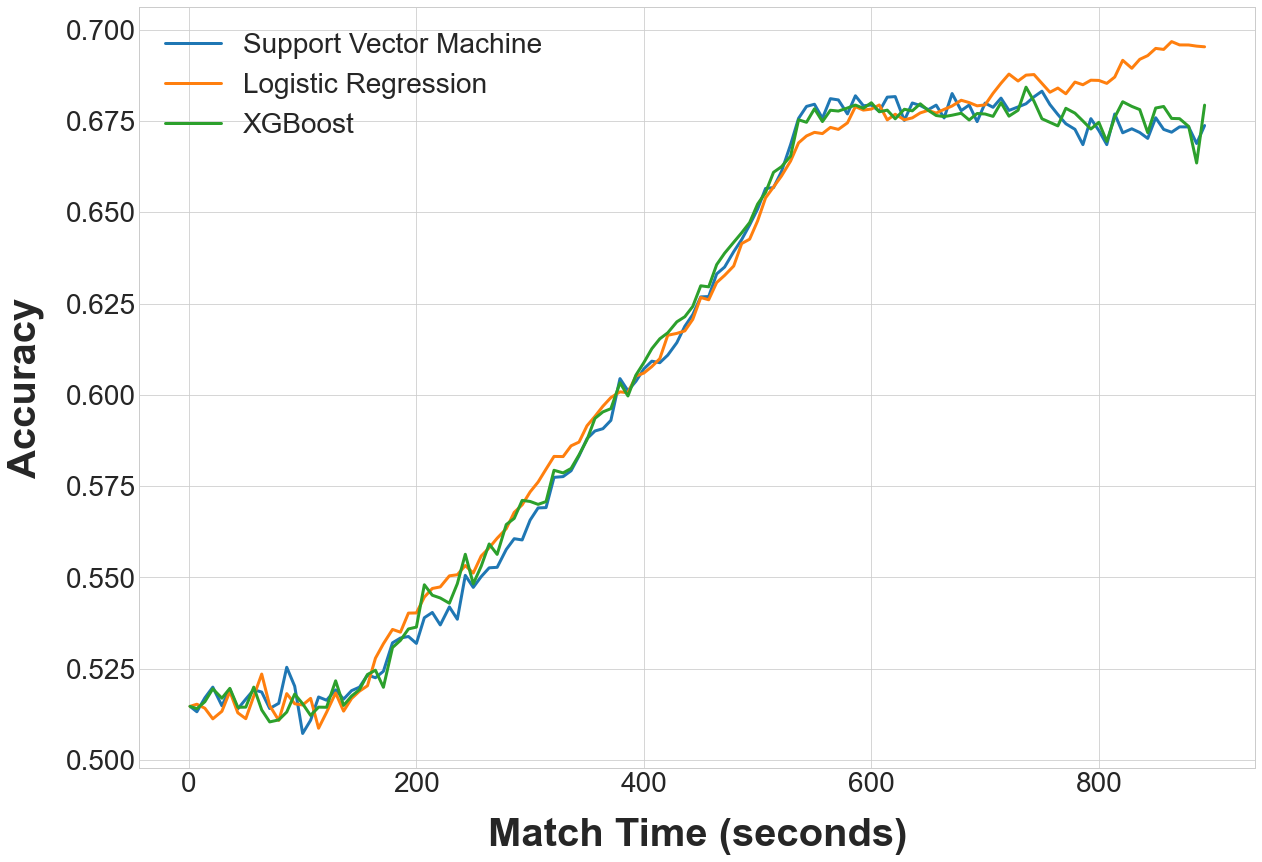

In [ ]:
# Plot each model's accuracy over time
import matplotlib.pyplot as plt

time = [round(i/22.4) if i > 1 else i for i in out_dict['gameloop']]

plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(20, 14))

ax.plot(time, out_dict['sv_accuracy'], label='Support Vector Machine', linewidth=3)
ax.plot(time, out_dict['lr_accuracy'], label='Logistic Regression', linewidth=3)
ax.plot(time, out_dict['xgb_accuracy'], label='XGBoost', linewidth=3)

ax.set_xlabel('Match Time (seconds)', fontsize=40, labelpad=20, fontdict=dict(weight='bold'))
ax.set_ylabel('Accuracy', fontsize=40, labelpad=22, fontdict=dict(weight='bold'))
plt.legend(fontsize=28)
plt.yticks(fontsize=28)
plt.xticks(fontsize=28)
plt.savefig('timeseries.pdf', dpi=600)
plt.show()